In [1]:
import sys
import os
import numpy as np
from scipy.stats import pearsonr
import pandas as pd
from matplotlib import pyplot as plt

sys.path.append('/home/ubuntu/repos/learning-habits-analysis')
from utils.analysis import compute_parametric_modulator, orthogonalize_modulator
from utils.data import sort_key

from nilearn.image import load_img, concat_imgs
from nilearn.plotting import plot_design_matrix
from nilearn.glm.first_level import make_first_level_design_matrix, FirstLevelModel

In [2]:
base_dir = '/home/ubuntu/data/social-risk'
behav_path = os.path.join(base_dir, 'analysis')

In [3]:
# Load the behav data
subjInfo = pd.read_csv(os.path.join(behav_path, 'SubjInfo.csv'))
bbt = pd.read_csv(os.path.join(behav_path, 'BevBigTable.csv'), index_col=[0,1,2])
bbt_raw = pd.read_csv(os.path.join(behav_path, 'BevBigTableRaw.csv'))
wtpT = pd.read_csv(os.path.join(behav_path, 'WTPTable.csv'))

bbt.index = bbt.index.set_levels([bbt.index.levels[0].map(lambda x: f'SUBJ_{x:02d}')] + bbt.index.levels[1:])

In [4]:
sub = 'SUBJ_01'
sub_dir = os.path.join(base_dir, sub, 'func')

In [5]:
# Load the imaging data
runs = [os.path.join(sub_dir, f'swra{sub}_sess{i}.nii') for i in range(1,4)]
confounds = [os.path.join(sub_dir, f'rp_a{sub}_sess{i}.txt') for i in range(1,4)]
# check that files exist
for run, confound in zip(runs, confounds):
    assert os.path.exists(run)
    assert os.path.exists(confound)

# Read confounds for each session and assign column names dynamically
confounds = [
    pd.read_csv(
        confound, 
        sep=r'\s+', 
        names=[f'Sn_{i+1}_R{j}' for j in range(1, 7)]
    ) 
    for i, confound in enumerate(confounds)
]

In [6]:
behav = bbt.loc[sub]

# Load SPM design matrix

In [7]:
spm_X = '/home/ubuntu/data/social-risk/analysis/samples/glm2_dm.csv'
spm_X = pd.read_csv(spm_X)

# Create a design matrix

In [8]:
TR = 3.
noise_model = 'ar1'
hrf_model = 'spm + derivative'
drift_model = 'cosine'
high_pass = 1/128

In [9]:
imgs = [load_img(run) for run in runs]
n_scans = [img.shape[-1] for img in imgs]

In [10]:
ft1 = np.arange(n_scans[0]) * TR
ft2 = np.arange(n_scans[1]) * TR + n_scans[0] * TR
ft3 = np.arange(n_scans[2]) * TR + (n_scans[0] + n_scans[1]) * TR

frametimes = np.concatenate([ft1, ft2, ft3])

In [11]:
# handle offset of sessions
offsets = [0, n_scans[0] * TR, (n_scans[0] + n_scans[1]) * TR]

In [12]:
behav_offset = behav.copy()
for i, run in enumerate([1, 2, 3]):
    mask = behav_offset.index.get_level_values(0) == run
    for col in behav_offset.columns[behav_offset.columns.str.contains('onset')]:
        behav_offset.loc[mask, col] = behav_offset.loc[mask, col] + offsets[i]

In [13]:
# masks
mask_social = behav_offset['trialSocial'] == 1
mask_juice = behav_offset['trialJuice'] == 1

# Info event
df_info = pd.DataFrame({
    'trial_type': 'Info',
    'onset': behav_offset['onsetINF'],
    'duration': 0,
    'run': behav_offset.index.get_level_values(0),
    'trial': behav_offset.index.get_level_values(1)
})
# Opt1Social event
df_opt1_social = pd.DataFrame({
    'trial_type': 'Opt1Social',
    'onset': behav_offset[mask_social]['onsetOPT1'],
    'duration': 0,
    'run': behav_offset[mask_social].index.get_level_values(0),
    'trial': behav_offset[mask_social].index.get_level_values(1),
    'Opt1SocialxWTP': behav_offset.loc[mask_social, 'WTPOpt1']
})

# Opt1Juice event
df_opt1_juice = pd.DataFrame({
    'trial_type': 'Opt1Juice',
    'onset': behav_offset[mask_juice]['onsetOPT1'],
    'duration': 0,
    'run': behav_offset[mask_juice].index.get_level_values(0),
    'trial': behav_offset[mask_juice].index.get_level_values(1),
    'Opt1JuicexWTP': behav_offset.loc[mask_juice, 'WTPOpt1']
})

# Opt2Social event
df_opt2_social = pd.DataFrame({
    'trial_type': 'Opt2Social',
    'onset': behav_offset[mask_social]['onsetOPT2'],
    'duration': 0,
    'run': behav_offset[mask_social].index.get_level_values(0),
    'trial': behav_offset[mask_social].index.get_level_values(1),
    'Opt2SocialxWTP': behav_offset.loc[mask_social, 'WTPOpt2']
})

# Opt2Juice event
df_opt2_juice = pd.DataFrame({
    'trial_type': 'Opt2Juice',
    'onset': behav_offset[mask_juice]['onsetOPT2'],
    'duration': 0,
    'run': behav_offset[mask_juice].index.get_level_values(0),
    'trial': behav_offset[mask_juice].index.get_level_values(1),
    'Opt2JuicexWTP': behav_offset.loc[mask_juice, 'WTPOpt2']
})

# Decision event
df_decision = pd.DataFrame({
    'trial_type': 'Decision',
    'onset': behav_offset['onsetDEC'],
    'duration': 0,
    'run': behav_offset.index.get_level_values(0),
    'trial': behav_offset.index.get_level_values(1)
})

# Feedback event
df_feedback = pd.DataFrame({
    'trial_type': 'Feedback',
    'onset': behav_offset['onsetFBK'],
    'duration': 0,
    'run': behav_offset.index.get_level_values(0),
    'trial': behav_offset.index.get_level_values(1)
})

In [14]:
# Put it all together
events = pd.concat([df_info, df_opt1_social, df_opt1_juice, df_opt2_social, df_opt2_juice, df_decision, df_feedback],
                   ignore_index=True)

events = events.sort_values(by='onset').reset_index(drop=True)

In [15]:
# demean confounds and put them together
for i in range(3):
    confounds[i] = confounds[i] - confounds[i].mean()
all_confounds = pd.concat(confounds, ignore_index=True).fillna(0.)

In [16]:
# split sessions
events['trial_type'] = 'Sn_' + events['run'].astype(str) + '_' + events['trial_type']

In [17]:
X = make_first_level_design_matrix(frametimes,
                                   events, 
                                   hrf_model=hrf_model, 
                                   drift_model=None,
                                   add_regs=all_confounds)
X = X.drop('constant', axis=1)

/home/ubuntu/miniforge3/envs/neuroim/lib/python3.10/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
Sn_1_Info, Sn_1_Opt1Juice, Sn_1_Opt2Juice, Sn_1_Decision, Sn_1_Feedback, Sn_1_Opt1Social, Sn_1_Opt2Social, Sn_2_Info, Sn_2_Opt1Juice, Sn_2_Opt2Juice, Sn_2_Decision, Sn_2_Feedback, Sn_2_Opt1Social, Sn_2_Opt2Social, Sn_3_Info, Sn_3_Opt1Juice, Sn_3_Opt2Juice, Sn_3_Decision, Sn_3_Feedback, Sn_3_Opt1Social, Sn_3_Opt2Social.
  warnings.warn(
/home/ubuntu/miniforge3/envs/neuroim/lib/python3.10/site-packages/nilearn/glm/first_level/experimental_paradigm.py:167: UserWarning: The following unexpected columns in events data will be ignored: Opt1SocialxWTP, run, Opt2JuicexWTP, Opt2SocialxWTP, Opt1JuicexWTP, trial
  warnings.warn(


In [18]:
parametric_modulators = {}

for s in range(1, 4):
    conditions = [
        (f'Sn_{s}_Opt1Social', 'Opt1SocialxWTP'),
        (f'Sn_{s}_Opt1Juice', 'Opt1JuicexWTP'),
        (f'Sn_{s}_Opt2Social', 'Opt2SocialxWTP'),
        (f'Sn_{s}_Opt2Juice', 'Opt2JuicexWTP')
    ]

    for condition, modulator in conditions:
        mod_name = f'Sn_{s}_'+modulator
        pm = compute_parametric_modulator(events, condition, modulator, frametimes, hrf_model, normalize='center')
        pm_ortho = orthogonalize_modulator(pm[:, 0], X[condition])
        parametric_modulators[mod_name] = pd.DataFrame({mod_name: pm_ortho,
                                                        mod_name+'_derivative': pm[:, 1]})

all_modulators = pd.concat(parametric_modulators.values(), axis=1)
all_modulators.index = X.index

In [19]:
X = pd.concat([X, all_modulators], axis=1)


In [20]:
# Sort columns before adding session dummies
X = X[sorted(X.columns, key=lambda col: (col.split('_')[1], col))]
# Sort same as spm design matrix
new_order = sorted(X.columns[:28], key=sort_key)
new_order = new_order + [col.replace('Sn_1', 'Sn_2') for col in new_order] + [col.replace('Sn_1', 'Sn_3') for col in new_order]
X = X[new_order]

In [21]:
# Add session dummy variables to the design matrix
session_dummy = np.eye(3).repeat(n_scans, axis=0)
session_df = pd.DataFrame(session_dummy, columns=[f'Sn_{i}_constant' for i in range(1, 4)], index=X.index)
X = pd.concat([X, session_df], axis=1)

<Axes: label='conditions', ylabel='scan number'>

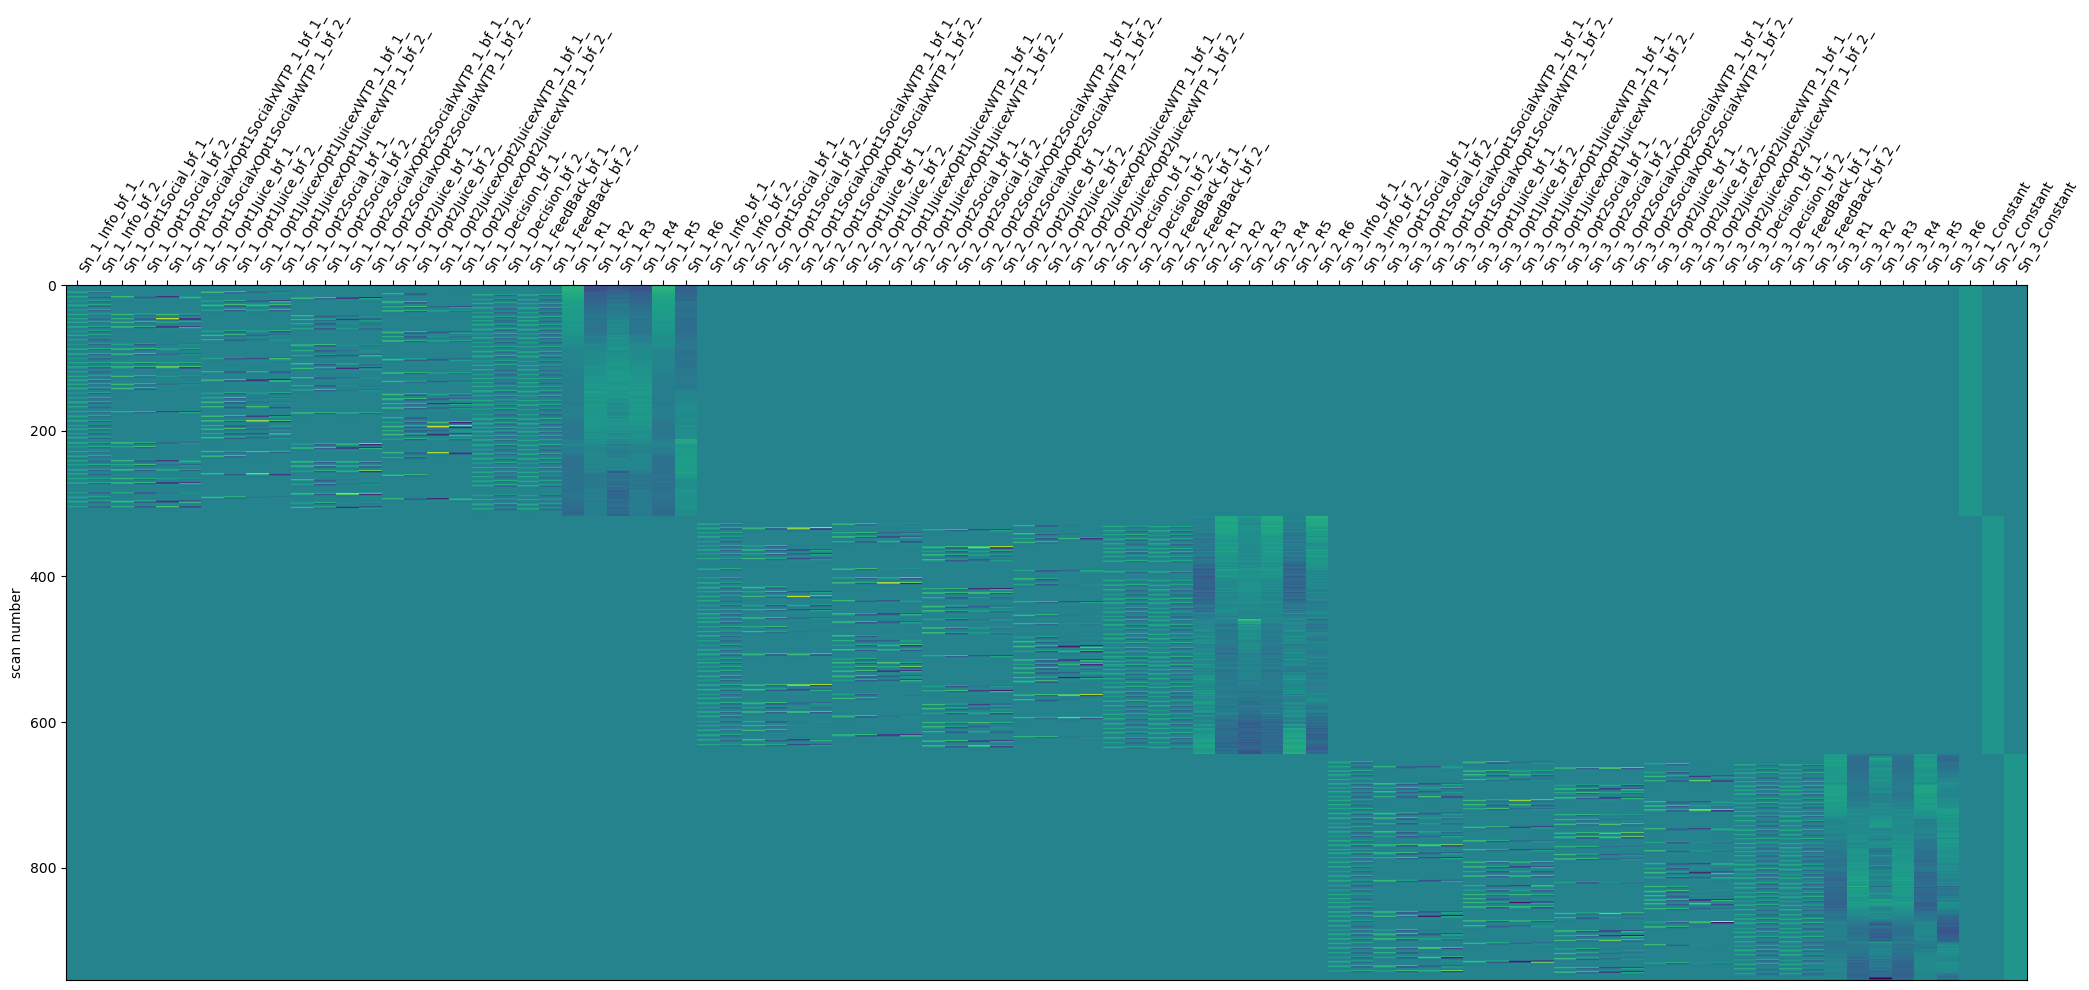

In [22]:
plot_design_matrix(spm_X)

In [23]:
dm_corr = []
scaling = []
for i, col in enumerate(X.columns):
    dm_corr.append(pearsonr(X[col], spm_X.iloc[:, i])[0])
    scaling.append(np.std(spm_X.iloc[:, i]) / np.std(X[col]))

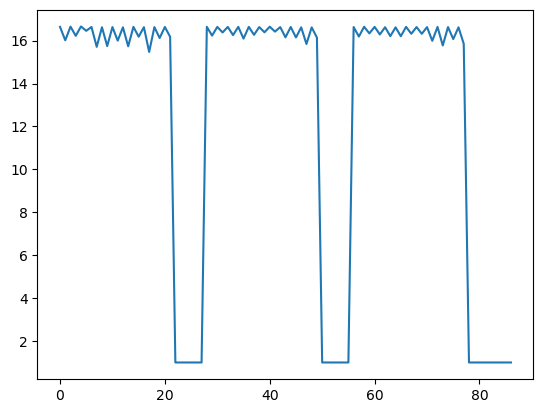

In [24]:
plt.plot(scaling)

# First level

In [25]:
concatenated_img = concat_imgs(imgs)

In [33]:
model = FirstLevelModel(t_r = TR,
                        smoothing_fwhm=None,
                        hrf_model=hrf_model,
                        noise_model=noise_model,
                        drift_model=None,
                        minimize_memory=False)

In [34]:
model = model.fit(concatenated_img, design_matrices=X)

In [35]:
model_spm = FirstLevelModel(t_r = TR,
                        smoothing_fwhm=None,
                        hrf_model=hrf_model,
                        noise_model=noise_model,
                        drift_model=None,
                        minimize_memory=False)

In [36]:
model_spm = model_spm.fit(concatenated_img, design_matrices=spm_X)

In [44]:
from nilearn.plotting import plot_stat_map

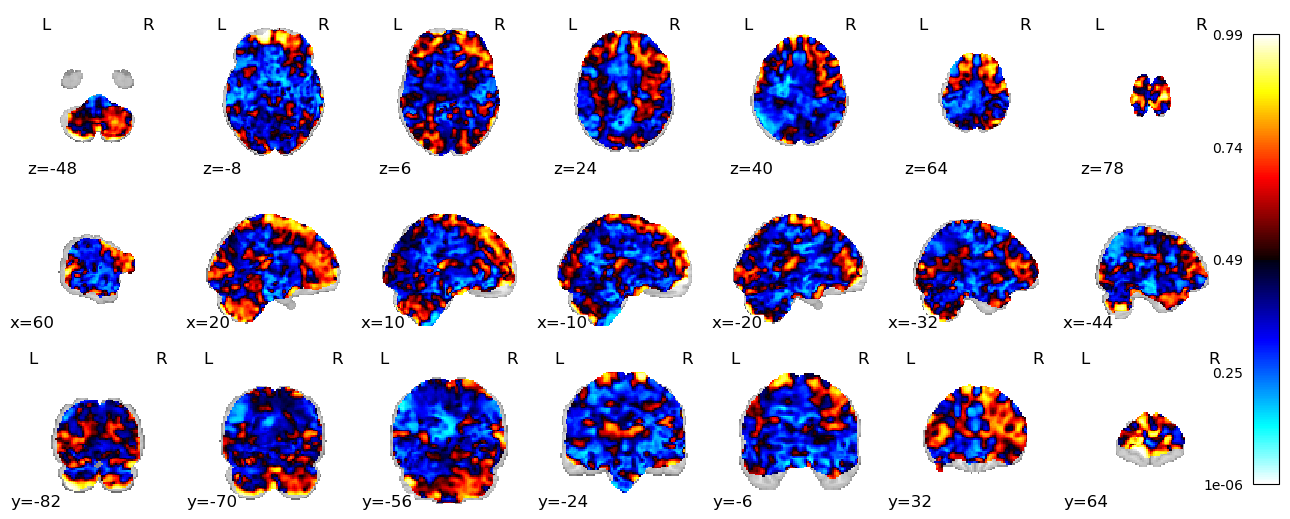

In [56]:
plot_stat_map(model.r_square[0], display_mode='mosaic')

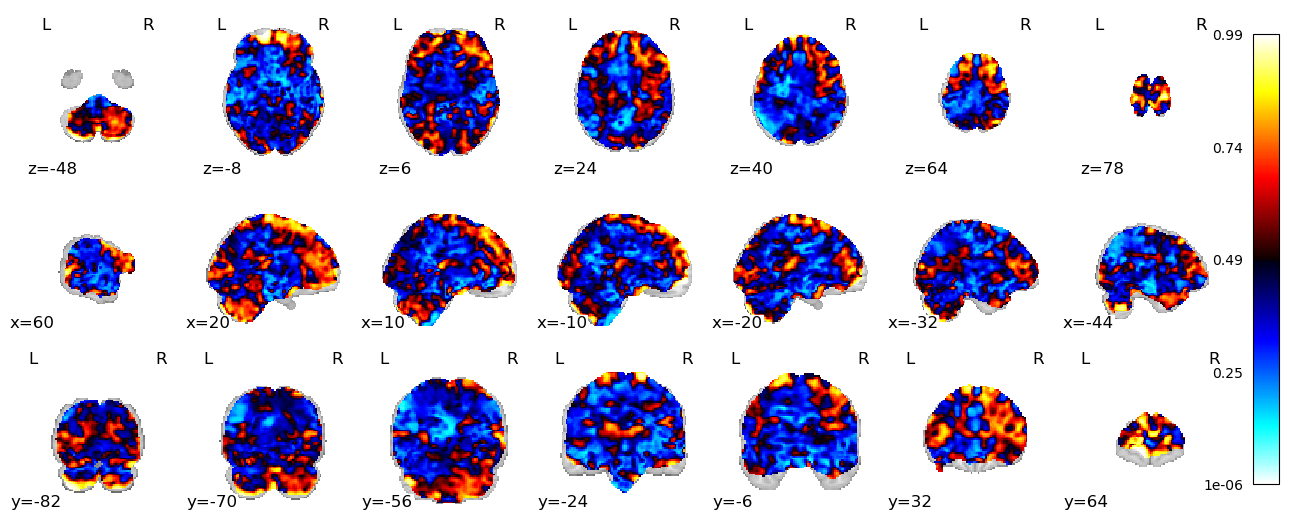

In [62]:
plot_stat_map(model_spm.r_square[0], display_mode='mosaic')


In [63]:
model.r_square[0].shape

(79, 95, 79, 1)

In [68]:
pearsonr(model_spm.r_square[0].get_fdata().ravel(), model.r_square[0].get_fdata().ravel())

PearsonRResult(statistic=0.9999694516001131, pvalue=0.0)